In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
import tushare as ts
from datetime import datetime
import yfinance as yf
 
import warnings

warnings.filterwarnings("ignore")

In [139]:
# ts.set_token('c39e3c5b040f85d3f794284d5c0626fb08581b8b965ae67208563727')

# pro = ts.pro_api()

# # Get stock data (example: get daily stock data for SZSE 002230)
# stock_data = pro.daily(ts_code='002230.SZ', start_date='20220101', end_date='20221231')

# print(stock_data)

# stock_data['trade_date'] = pd.to_datetime(stock_data['trade_date'])

stock_data = yf.download('BIDU', start='2020-01-01')

stock_data['date'] = stock_data.index
stock_data['date'] = pd.to_datetime(stock_data['date'])

# apple['date'] = apple.index
# apple['date'] = pd.to_datetime(apple['date'])
# apple.info

[*********************100%%**********************]  1 of 1 completed


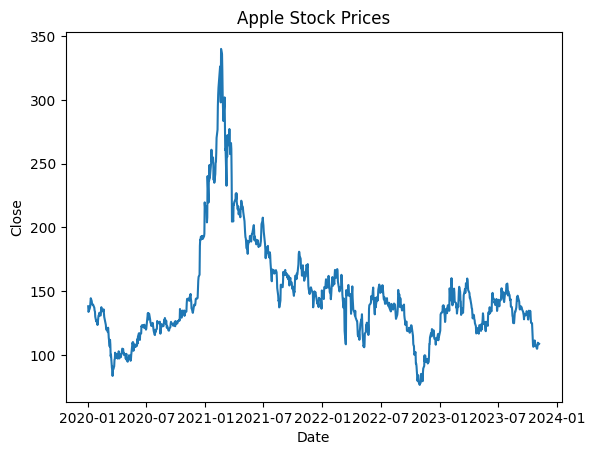

In [140]:
plt.plot(stock_data['date'],stock_data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [141]:
close_data = stock_data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .5))
print(dataset)
print(training)

[[138.22000122]
 [133.80000305]
 [135.94000244]
 [136.69999695]
 [137.83000183]
 [140.86000061]
 [144.50999451]
 [142.25999451]
 [140.03999329]
 [139.3999939 ]
 [139.49000549]
 [139.61000061]
 [137.1000061 ]
 [134.80000305]
 [134.19999695]
 [130.        ]
 [126.27999878]
 [126.93000031]
 [126.47000122]
 [125.73999786]
 [123.55999756]
 [130.49000549]
 [131.36999512]
 [130.75      ]
 [133.16000366]
 [130.91000366]
 [131.05000305]
 [133.99000549]
 [137.49000549]
 [135.17999268]
 [134.57000732]
 [134.17999268]
 [135.80999756]
 [132.46000671]
 [129.80000305]
 [125.83000183]
 [124.43000031]
 [123.54000092]
 [119.91000366]
 [119.98000336]
 [120.76999664]
 [117.97000122]
 [121.41000366]
 [118.23999786]
 [113.73999786]
 [106.65000153]
 [111.91000366]
 [108.25      ]
 [ 99.        ]
 [100.29000092]
 [ 89.68000031]
 [ 91.12999725]
 [ 83.62000275]
 [ 89.62000275]
 [ 88.66000366]
 [ 91.22000122]
 [ 96.43000031]
 [ 96.91999817]
 [101.81999969]
 [ 97.62999725]
 [ 98.94999695]
 [100.79000092]
 [ 97.68

In [142]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [143]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
print(model.summary())


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 60, 64)            16896     
                                                                 
 lstm_27 (LSTM)              (None, 64)                33024     
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [144]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)


Epoch 1/10
14/14 [==============================] - 2s 24ms/step - loss: 0.0377
Epoch 2/10
14/14 [==============================] - 0s 24ms/step - loss: 0.0140
Epoch 3/10
14/14 [==============================] - 0s 25ms/step - loss: 0.0093
Epoch 4/10
14/14 [==============================] - 0s 25ms/step - loss: 0.0081
Epoch 5/10
14/14 [==============================] - 0s 22ms/step - loss: 0.0092
Epoch 6/10
14/14 [==============================] - 0s 23ms/step - loss: 0.0091
Epoch 7/10
14/14 [==============================] - 0s 23ms/step - loss: 0.0098
Epoch 8/10
14/14 [==============================] - 0s 24ms/step - loss: 0.0082
Epoch 9/10
14/14 [==============================] - 0s 24ms/step - loss: 0.0072
Epoch 10/10
14/14 [==============================] - 0s 23ms/step - loss: 0.0062


In [145]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


16/16 [==============================] - 0s 6ms/step
MSE 201.46436753498435
RMSE 14.1938144110378


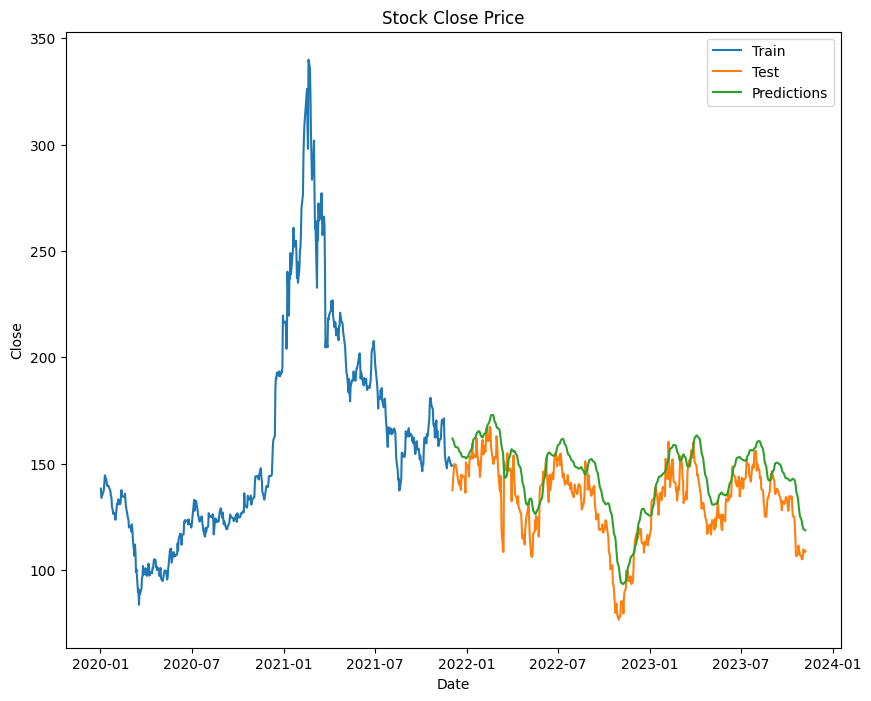

In [146]:
train = stock_data[:training]
test = stock_data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['Close'])
plt.plot(test['date'], test[['Close', 'Predictions']])
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
